### D19026 - Rahul Aggarwal 

In [1]:
# Import necessary packages

import os
from pathlib import Path
import torch
from torch.utils.data import TensorDataset ,DataLoader
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torch import nn
import helper
import matplotlib.pyplot as plt

In [3]:
# Load data

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.shape,test.shape

((42000, 785), (28000, 784))

In [4]:
# Split input and target variable

x=train.drop("label",axis=1)
y=np.array(train['label'])
x.shape,y.shape

((42000, 784), (42000,))

In [5]:
# Train-test split

torch_X_train = torch.from_numpy(x.values).type(torch.FloatTensor)/255
torch_y_train = torch.from_numpy(y).type(torch.LongTensor)
myDataset = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
valid_no  = int(0.2 * len(myDataset))

# so divide the data into trainset and testset
trainSet,testSet = torch.utils.data.random_split(myDataset,(len(myDataset)-valid_no,valid_no))
print(f"len of trainSet {len(trainSet)} , len of testSet {len(testSet)}")
batch_size=64
train_loader  = DataLoader(trainSet , batch_size=batch_size ,shuffle=True) 
test_loader  = DataLoader(testSet , batch_size=batch_size ,shuffle=True)

len of trainSet 33600 , len of testSet 8400


#### Experiment :1 - (SGD optimizer) , Epoch : 5 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/5..  Training Loss: 1.171..  Test Loss: 0.437..  Test Accuracy: 0.874
Epoch: 2/5..  Training Loss: 0.441..  Test Loss: 0.310..  Test Accuracy: 0.907
Epoch: 3/5..  Training Loss: 0.337..  Test Loss: 0.255..  Test Accuracy: 0.925
Epoch: 4/5..  Training Loss: 0.283..  Test Loss: 0.221..  Test Accuracy: 0.935
Epoch: 5/5..  Training Loss: 0.241..  Test Loss: 0.193..  Test Accuracy: 0.943
126.60577742010355


[]

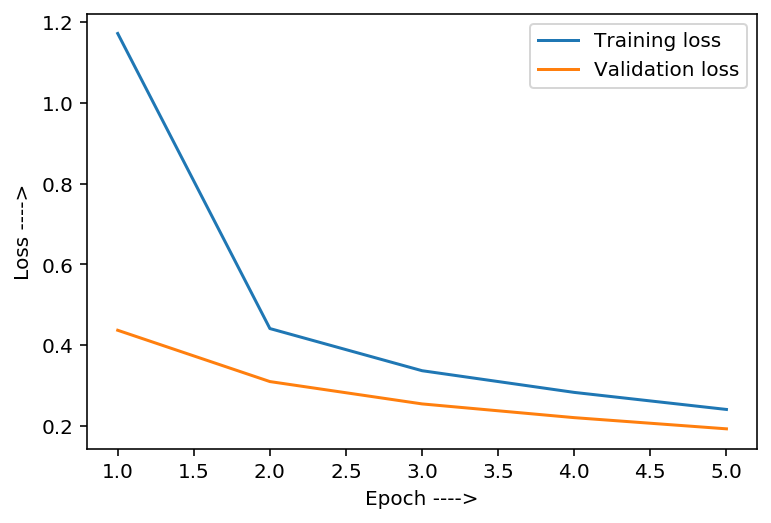

In [6]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

print("No Of Parameters",sum([p.numel() for p in model.parameters()]))
# Defining Optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.8)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (SGD optimizer) , Epoch : 10 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/10..  Training Loss: 1.109..  Test Loss: 0.418..  Test Accuracy: 0.879
Epoch: 2/10..  Training Loss: 0.428..  Test Loss: 0.307..  Test Accuracy: 0.908
Epoch: 3/10..  Training Loss: 0.331..  Test Loss: 0.249..  Test Accuracy: 0.925
Epoch: 4/10..  Training Loss: 0.275..  Test Loss: 0.211..  Test Accuracy: 0.935
Epoch: 5/10..  Training Loss: 0.231..  Test Loss: 0.185..  Test Accuracy: 0.943
Epoch: 6/10..  Training Loss: 0.202..  Test Loss: 0.168..  Test Accuracy: 0.949
Epoch: 7/10..  Training Loss: 0.184..  Test Loss: 0.158..  Test Accuracy: 0.951
Epoch: 8/10..  Training Loss: 0.167..  Test Loss: 0.144..  Test Accuracy: 0.957
Epoch: 9/10..  Training Loss: 0.150..  Test Loss: 0.136..  Test Accuracy: 0.958
Epoch: 10/10..  Training Loss: 0.140..  Test Loss: 0.127..  Test Accuracy: 0.962
73.51738564670086


[]

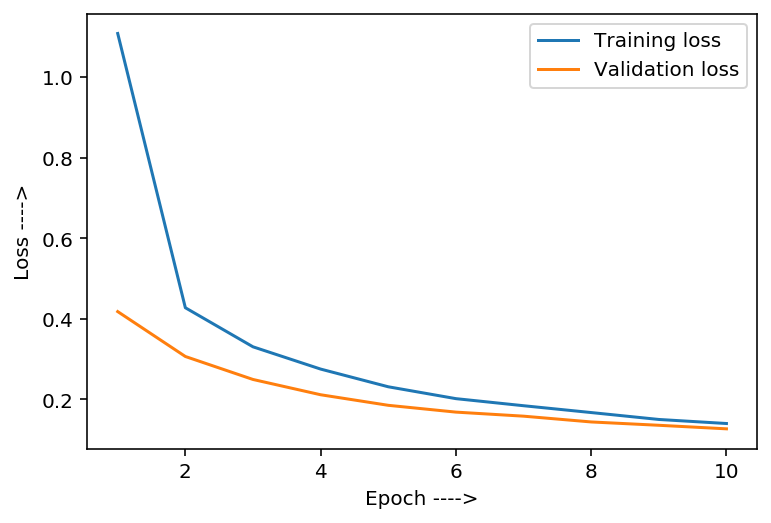

In [7]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.8)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :2 - (SGD optimizer) , Epoch : 5 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 242762
Epoch: 1/5..  Training Loss: 1.008..  Test Loss: 0.336..  Test Accuracy: 0.899
Epoch: 2/5..  Training Loss: 0.296..  Test Loss: 0.213..  Test Accuracy: 0.934
Epoch: 3/5..  Training Loss: 0.193..  Test Loss: 0.159..  Test Accuracy: 0.953
Epoch: 4/5..  Training Loss: 0.145..  Test Loss: 0.136..  Test Accuracy: 0.959
Epoch: 5/5..  Training Loss: 0.115..  Test Loss: 0.116..  Test Accuracy: 0.967
60.546690604649484


[]

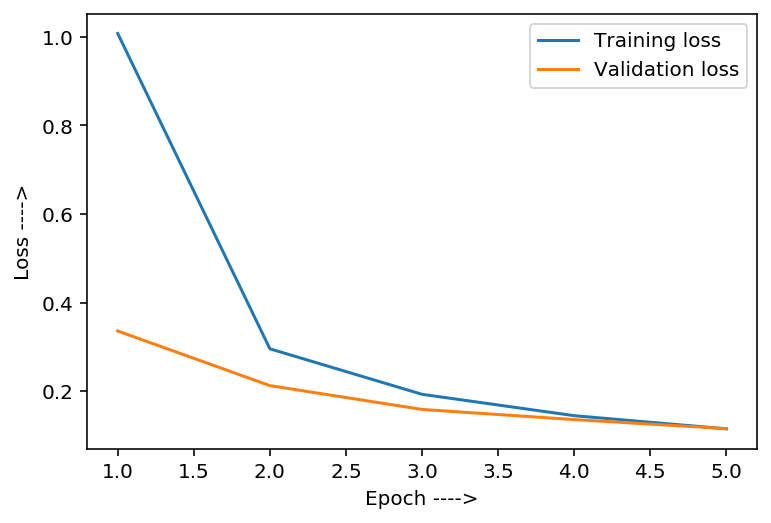

In [8]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.SGD(model.parameters(),lr=0.02,momentum=0.8)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (SGD optimizer) , Epoch : 10 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 242762
Epoch: 1/10..  Training Loss: 0.913..  Test Loss: 0.325..  Test Accuracy: 0.905
Epoch: 2/10..  Training Loss: 0.281..  Test Loss: 0.196..  Test Accuracy: 0.941
Epoch: 3/10..  Training Loss: 0.187..  Test Loss: 0.159..  Test Accuracy: 0.952
Epoch: 4/10..  Training Loss: 0.144..  Test Loss: 0.135..  Test Accuracy: 0.959
Epoch: 5/10..  Training Loss: 0.114..  Test Loss: 0.118..  Test Accuracy: 0.965
Epoch: 6/10..  Training Loss: 0.096..  Test Loss: 0.113..  Test Accuracy: 0.969
Epoch: 7/10..  Training Loss: 0.080..  Test Loss: 0.106..  Test Accuracy: 0.966
Epoch: 8/10..  Training Loss: 0.069..  Test Loss: 0.104..  Test Accuracy: 0.969
Epoch: 9/10..  Training Loss: 0.060..  Test Loss: 0.099..  Test Accuracy: 0.972
Epoch: 10/10..  Training Loss: 0.049..  Test Loss: 0.099..  Test Accuracy: 0.972
25.907955973176286


[]

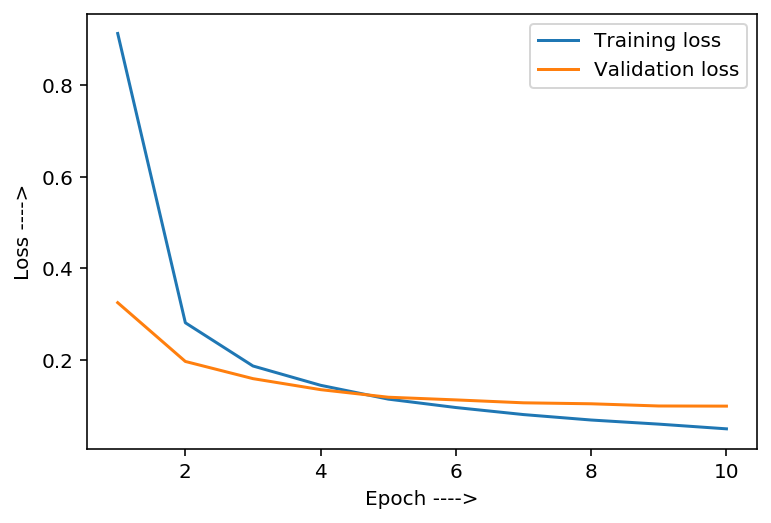

In [9]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.1),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.SGD(model.parameters(),lr=0.02,momentum=0.8,nesterov=True)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :3 - (Adagrad optimizer) , Epoch : 5 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 52650
Epoch: 1/5..  Training Loss: 0.629..  Test Loss: 0.333..  Test Accuracy: 0.901
Epoch: 2/5..  Training Loss: 0.402..  Test Loss: 0.277..  Test Accuracy: 0.917
Epoch: 3/5..  Training Loss: 0.349..  Test Loss: 0.249..  Test Accuracy: 0.925
Epoch: 4/5..  Training Loss: 0.311..  Test Loss: 0.228..  Test Accuracy: 0.933
Epoch: 5/5..  Training Loss: 0.292..  Test Loss: 0.214..  Test Accuracy: 0.938
153.0985412299633


[]

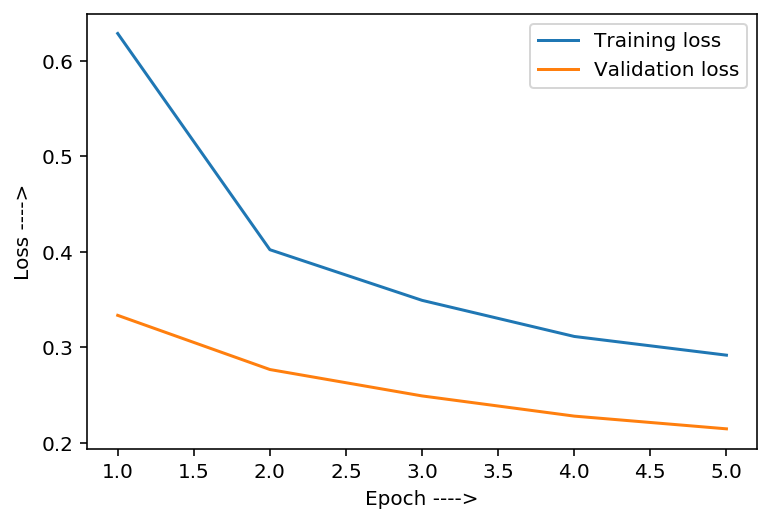

In [10]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adagrad optimizer) , Epoch : 10 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 52650
Epoch: 1/10..  Training Loss: 0.625..  Test Loss: 0.340..  Test Accuracy: 0.899
Epoch: 2/10..  Training Loss: 0.400..  Test Loss: 0.281..  Test Accuracy: 0.913
Epoch: 3/10..  Training Loss: 0.351..  Test Loss: 0.251..  Test Accuracy: 0.921
Epoch: 4/10..  Training Loss: 0.320..  Test Loss: 0.237..  Test Accuracy: 0.926
Epoch: 5/10..  Training Loss: 0.297..  Test Loss: 0.225..  Test Accuracy: 0.931
Epoch: 6/10..  Training Loss: 0.280..  Test Loss: 0.214..  Test Accuracy: 0.934
Epoch: 7/10..  Training Loss: 0.272..  Test Loss: 0.205..  Test Accuracy: 0.937
Epoch: 8/10..  Training Loss: 0.264..  Test Loss: 0.200..  Test Accuracy: 0.939
Epoch: 9/10..  Training Loss: 0.253..  Test Loss: 0.195..  Test Accuracy: 0.941
Epoch: 10/10..  Training Loss: 0.244..  Test Loss: 0.189..  Test Accuracy: 0.943
128.22981008142233


[]

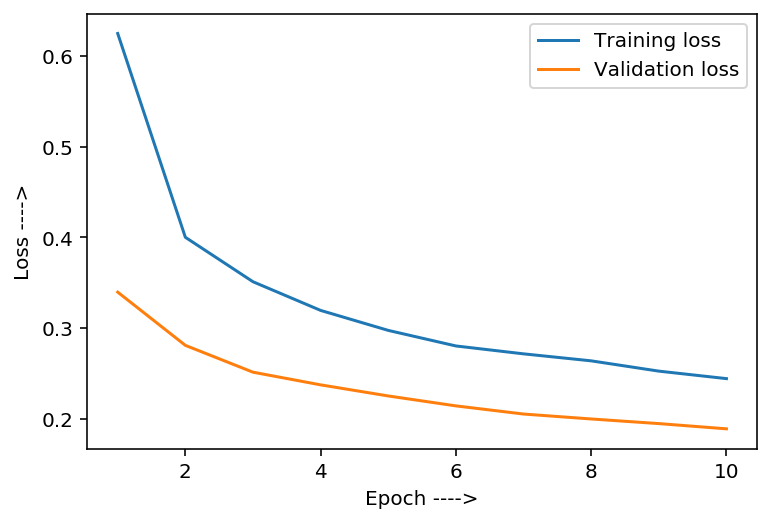

In [11]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :4 - (Adagrad optimizer) , Epoch : 5 , Hidden Layer : 1 , Sigmoid Activation

No Of Parameters 109386
Epoch: 1/5..  Training Loss: 0.942..  Test Loss: 0.473..  Test Accuracy: 0.879
Epoch: 2/5..  Training Loss: 0.465..  Test Loss: 0.358..  Test Accuracy: 0.901
Epoch: 3/5..  Training Loss: 0.372..  Test Loss: 0.315..  Test Accuracy: 0.909
Epoch: 4/5..  Training Loss: 0.327..  Test Loss: 0.292..  Test Accuracy: 0.912
Epoch: 5/5..  Training Loss: 0.297..  Test Loss: 0.279..  Test Accuracy: 0.916
155.96499164402485


[]

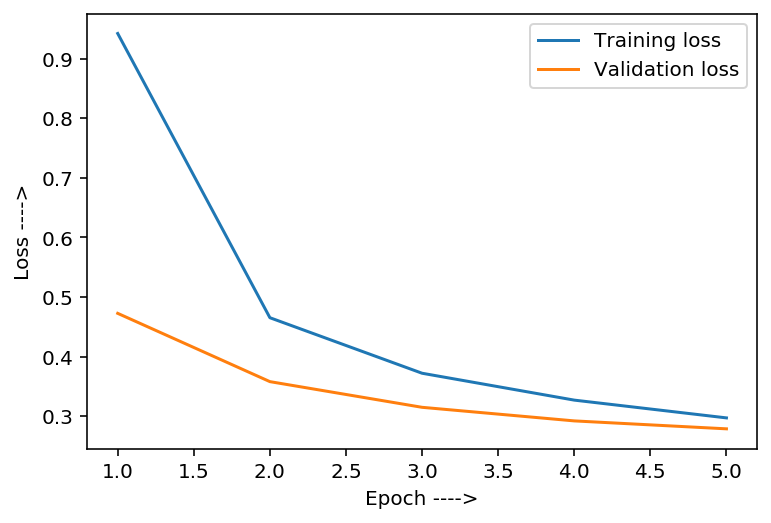

In [12]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.Sigmoid(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.Sigmoid(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adagrad optimizer) , Epoch : 10 , Hidden Layer : 1 , Sigmoid Activation

No Of Parameters 109386
Epoch: 1/10..  Training Loss: 0.949..  Test Loss: 0.503..  Test Accuracy: 0.874
Epoch: 2/10..  Training Loss: 0.487..  Test Loss: 0.383..  Test Accuracy: 0.895
Epoch: 3/10..  Training Loss: 0.391..  Test Loss: 0.339..  Test Accuracy: 0.903
Epoch: 4/10..  Training Loss: 0.344..  Test Loss: 0.315..  Test Accuracy: 0.907
Epoch: 5/10..  Training Loss: 0.314..  Test Loss: 0.294..  Test Accuracy: 0.912
Epoch: 6/10..  Training Loss: 0.294..  Test Loss: 0.280..  Test Accuracy: 0.918
Epoch: 7/10..  Training Loss: 0.278..  Test Loss: 0.275..  Test Accuracy: 0.918
Epoch: 8/10..  Training Loss: 0.266..  Test Loss: 0.265..  Test Accuracy: 0.920
Epoch: 9/10..  Training Loss: 0.257..  Test Loss: 0.257..  Test Accuracy: 0.924
Epoch: 10/10..  Training Loss: 0.247..  Test Loss: 0.250..  Test Accuracy: 0.925
129.92229975759983


[]

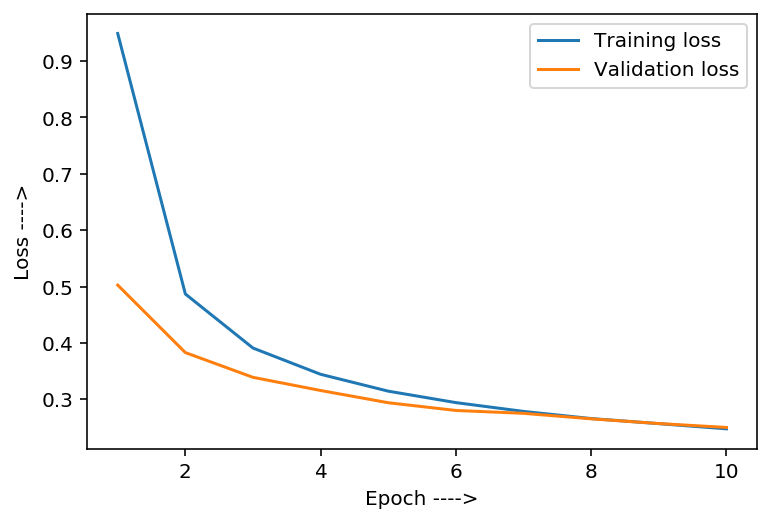

In [13]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.Sigmoid(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.Sigmoid(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :5 - (Adagrad optimizer) , Epoch : 5 , Hidden Layer : 2 , Sigmoid Activation

No Of Parameters 219818
Epoch: 1/5..  Training Loss: 1.347..  Test Loss: 0.900..  Test Accuracy: 0.737
Epoch: 2/5..  Training Loss: 0.807..  Test Loss: 0.672..  Test Accuracy: 0.802
Epoch: 3/5..  Training Loss: 0.626..  Test Loss: 0.524..  Test Accuracy: 0.886
Epoch: 4/5..  Training Loss: 0.496..  Test Loss: 0.419..  Test Accuracy: 0.908
Epoch: 5/5..  Training Loss: 0.409..  Test Loss: 0.362..  Test Accuracy: 0.917
214.98156362771988


[]

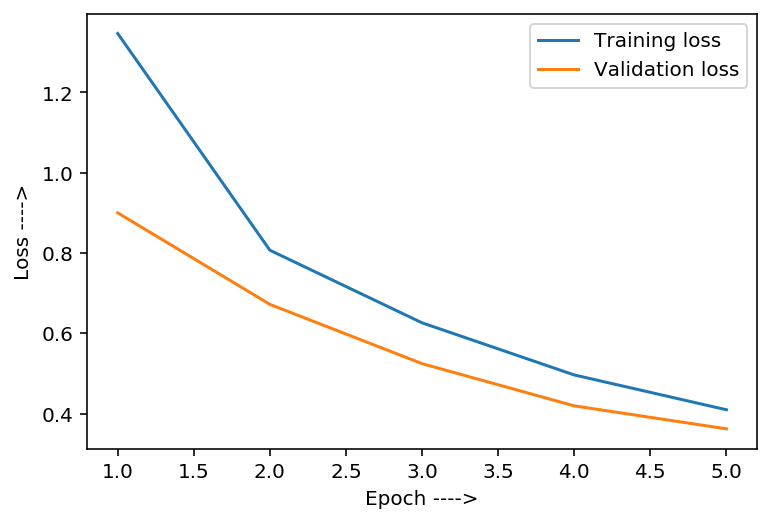

In [14]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adagrad optimizer) , Epoch : 10 , Hidden Layer : 2 , Sigmoid Activation

No Of Parameters 219818
Epoch: 1/10..  Training Loss: 1.504..  Test Loss: 0.512..  Test Accuracy: 0.859
Epoch: 2/10..  Training Loss: 0.317..  Test Loss: 0.211..  Test Accuracy: 0.942
Epoch: 3/10..  Training Loss: 0.186..  Test Loss: 0.170..  Test Accuracy: 0.954
Epoch: 4/10..  Training Loss: 0.138..  Test Loss: 0.160..  Test Accuracy: 0.956
Epoch: 5/10..  Training Loss: 0.111..  Test Loss: 0.145..  Test Accuracy: 0.964
Epoch: 6/10..  Training Loss: 0.093..  Test Loss: 0.141..  Test Accuracy: 0.963
Epoch: 7/10..  Training Loss: 0.079..  Test Loss: 0.130..  Test Accuracy: 0.969
Epoch: 8/10..  Training Loss: 0.071..  Test Loss: 0.132..  Test Accuracy: 0.967
Epoch: 9/10..  Training Loss: 0.063..  Test Loss: 0.124..  Test Accuracy: 0.970
Epoch: 10/10..  Training Loss: 0.060..  Test Loss: 0.131..  Test Accuracy: 0.968
31.370437087491155


[]

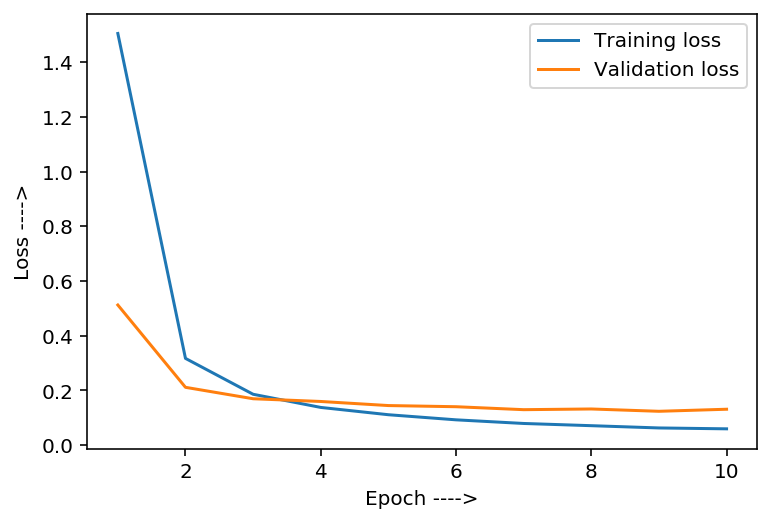

In [15]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.1),
                      nn.Sigmoid(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-1,lr_decay=1e-7)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :6 - (Adagrad optimizer) , Epoch : 5 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 219818
Epoch: 1/5..  Training Loss: 0.528..  Test Loss: 0.251..  Test Accuracy: 0.927
Epoch: 2/5..  Training Loss: 0.283..  Test Loss: 0.196..  Test Accuracy: 0.943
Epoch: 3/5..  Training Loss: 0.226..  Test Loss: 0.168..  Test Accuracy: 0.950
Epoch: 4/5..  Training Loss: 0.199..  Test Loss: 0.155..  Test Accuracy: 0.954
Epoch: 5/5..  Training Loss: 0.174..  Test Loss: 0.143..  Test Accuracy: 0.958
91.50728454068303


[]

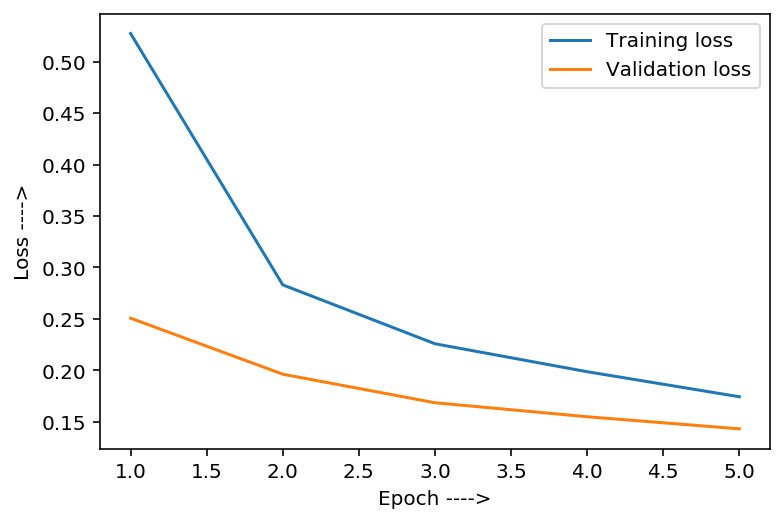

In [16]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adagrad optimizer) , Epoch : 10 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 219818
Epoch: 1/10..  Training Loss: 0.525..  Test Loss: 0.245..  Test Accuracy: 0.928
Epoch: 2/10..  Training Loss: 0.277..  Test Loss: 0.191..  Test Accuracy: 0.946
Epoch: 3/10..  Training Loss: 0.222..  Test Loss: 0.168..  Test Accuracy: 0.952
Epoch: 4/10..  Training Loss: 0.197..  Test Loss: 0.157..  Test Accuracy: 0.955
Epoch: 5/10..  Training Loss: 0.175..  Test Loss: 0.147..  Test Accuracy: 0.958
Epoch: 6/10..  Training Loss: 0.158..  Test Loss: 0.138..  Test Accuracy: 0.960
Epoch: 7/10..  Training Loss: 0.147..  Test Loss: 0.134..  Test Accuracy: 0.962
Epoch: 8/10..  Training Loss: 0.136..  Test Loss: 0.129..  Test Accuracy: 0.963
Epoch: 9/10..  Training Loss: 0.128..  Test Loss: 0.122..  Test Accuracy: 0.965
Epoch: 10/10..  Training Loss: 0.119..  Test Loss: 0.123..  Test Accuracy: 0.965
62.336609727703035


[]

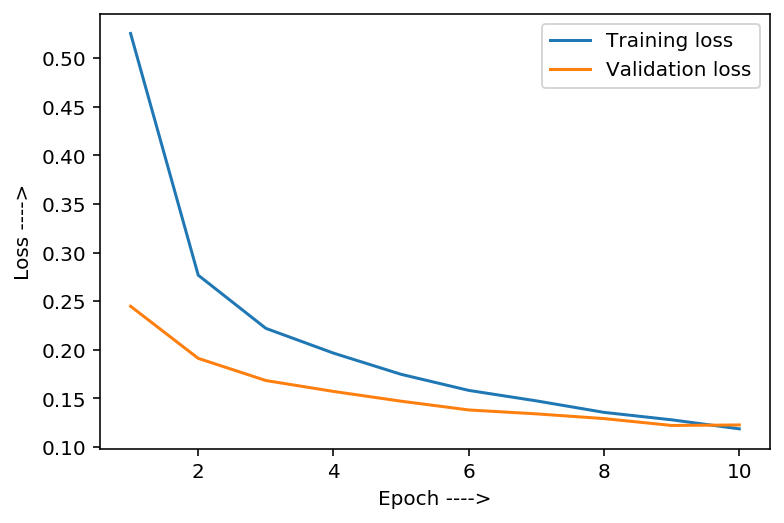

In [17]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(32, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adagrad(model.parameters(),lr=1e-2,lr_decay=1e-6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :7 - (RMSprop optimizer) , Epoch : 5 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 218058
Epoch: 1/5..  Training Loss: 2.414..  Test Loss: 2.176..  Test Accuracy: 0.157
Epoch: 2/5..  Training Loss: 2.455..  Test Loss: 2.136..  Test Accuracy: 0.169
Epoch: 3/5..  Training Loss: 2.294..  Test Loss: 2.102..  Test Accuracy: 0.198
Epoch: 4/5..  Training Loss: 2.345..  Test Loss: 2.030..  Test Accuracy: 0.222
Epoch: 5/5..  Training Loss: 2.527..  Test Loss: 2.110..  Test Accuracy: 0.197
1326.6138912439346


[]

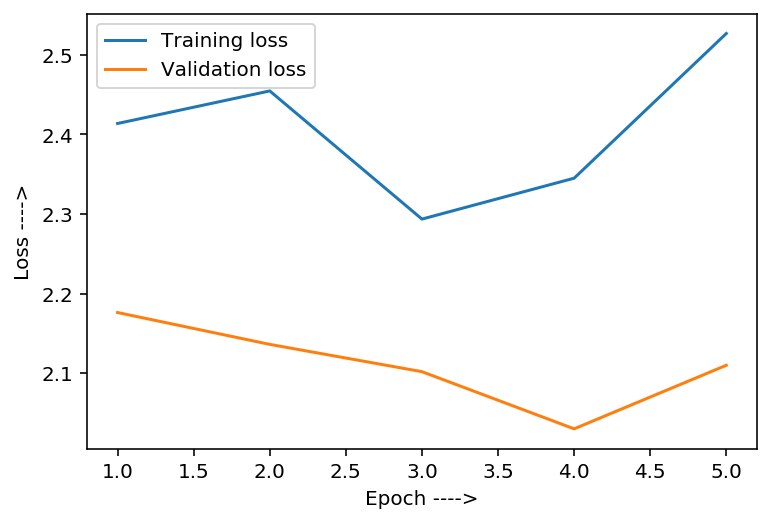

In [18]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.RMSprop(model.parameters(),lr=1e-2,alpha=0.88,momentum=0.9)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (RMSprop optimizer) , Epoch : 10 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 218058
Epoch: 1/10..  Training Loss: 0.926..  Test Loss: 0.492..  Test Accuracy: 0.872
Epoch: 2/10..  Training Loss: 1.129..  Test Loss: 0.550..  Test Accuracy: 0.857
Epoch: 3/10..  Training Loss: 1.369..  Test Loss: 0.647..  Test Accuracy: 0.827
Epoch: 4/10..  Training Loss: 1.613..  Test Loss: 0.884..  Test Accuracy: 0.760
Epoch: 5/10..  Training Loss: 1.785..  Test Loss: 1.125..  Test Accuracy: 0.697
Epoch: 6/10..  Training Loss: 1.748..  Test Loss: 1.026..  Test Accuracy: 0.671
Epoch: 7/10..  Training Loss: 1.894..  Test Loss: 1.098..  Test Accuracy: 0.665
Epoch: 8/10..  Training Loss: 1.924..  Test Loss: 1.151..  Test Accuracy: 0.608
Epoch: 9/10..  Training Loss: 2.039..  Test Loss: 1.130..  Test Accuracy: 0.693
Epoch: 10/10..  Training Loss: 2.265..  Test Loss: 1.252..  Test Accuracy: 0.586
1189.162191271782


[]

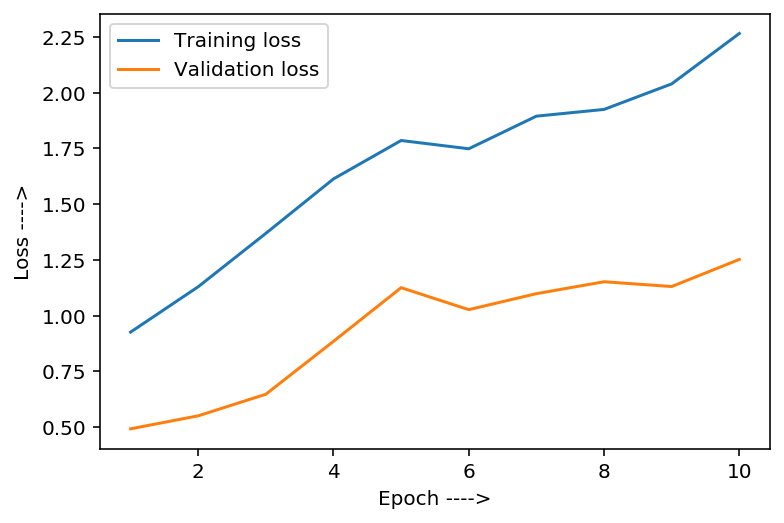

In [19]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 256),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(256, 64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.RMSprop(model.parameters(),lr=1e-3,alpha=0.85,momentum=0.95)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :8 - (Adam optimizer) , Epoch : 5 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/5..  Training Loss: 0.380..  Test Loss: 0.214..  Test Accuracy: 0.939
Epoch: 2/5..  Training Loss: 0.253..  Test Loss: 0.218..  Test Accuracy: 0.938
Epoch: 3/5..  Training Loss: 0.233..  Test Loss: 0.166..  Test Accuracy: 0.954
Epoch: 4/5..  Training Loss: 0.208..  Test Loss: 0.198..  Test Accuracy: 0.951
Epoch: 5/5..  Training Loss: 0.198..  Test Loss: 0.186..  Test Accuracy: 0.954
104.10050944704562


[]

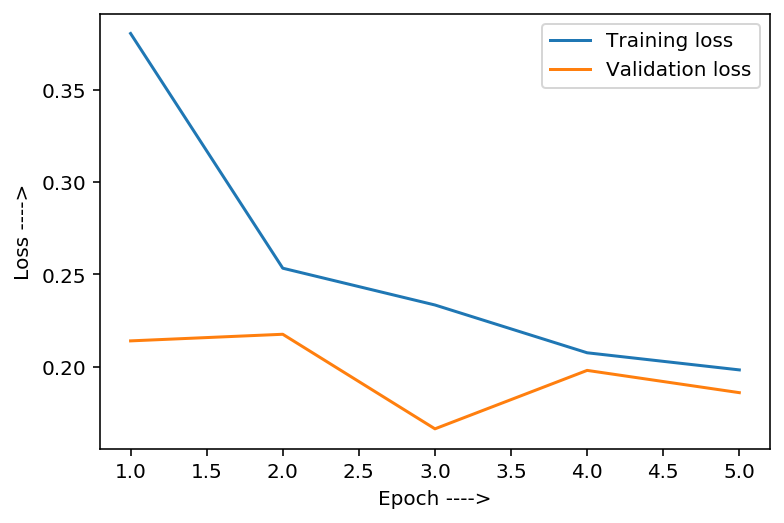

In [20]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adam(model.parameters(),lr=1e-2,eps=1e-7)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adam optimizer) , Epoch : 10 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/10..  Training Loss: 0.382..  Test Loss: 0.205..  Test Accuracy: 0.940
Epoch: 2/10..  Training Loss: 0.264..  Test Loss: 0.187..  Test Accuracy: 0.945
Epoch: 3/10..  Training Loss: 0.232..  Test Loss: 0.173..  Test Accuracy: 0.950
Epoch: 4/10..  Training Loss: 0.222..  Test Loss: 0.181..  Test Accuracy: 0.952
Epoch: 5/10..  Training Loss: 0.195..  Test Loss: 0.156..  Test Accuracy: 0.958
Epoch: 6/10..  Training Loss: 0.196..  Test Loss: 0.170..  Test Accuracy: 0.955
Epoch: 7/10..  Training Loss: 0.194..  Test Loss: 0.179..  Test Accuracy: 0.954
Epoch: 8/10..  Training Loss: 0.191..  Test Loss: 0.182..  Test Accuracy: 0.955
Epoch: 9/10..  Training Loss: 0.190..  Test Loss: 0.159..  Test Accuracy: 0.961
Epoch: 10/10..  Training Loss: 0.177..  Test Loss: 0.215..  Test Accuracy: 0.949
93.1688038399443


[]

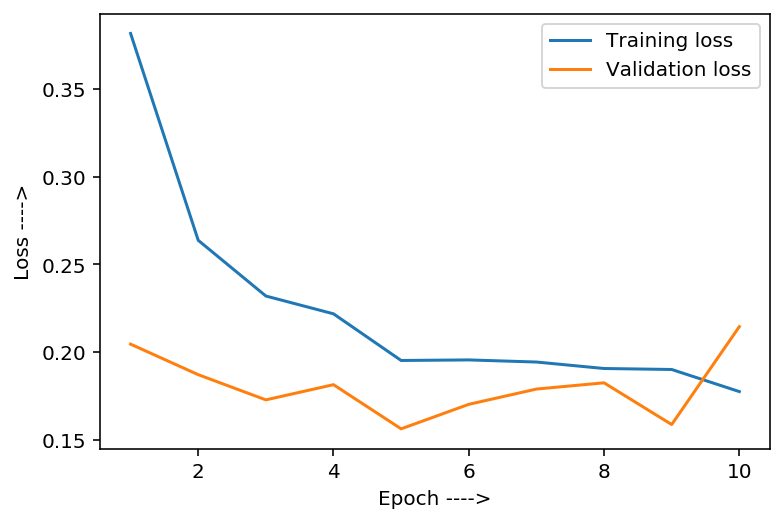

In [21]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adam(model.parameters(),lr=1e-2,eps=1e-7)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :9 - (Adadelta optimizer) , Epoch : 5 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/5..  Training Loss: 0.592..  Test Loss: 0.253..  Test Accuracy: 0.925
Epoch: 2/5..  Training Loss: 0.272..  Test Loss: 0.181..  Test Accuracy: 0.946
Epoch: 3/5..  Training Loss: 0.212..  Test Loss: 0.153..  Test Accuracy: 0.955
Epoch: 4/5..  Training Loss: 0.175..  Test Loss: 0.134..  Test Accuracy: 0.960
Epoch: 5/5..  Training Loss: 0.157..  Test Loss: 0.127..  Test Accuracy: 0.963
82.37891557440162


[]

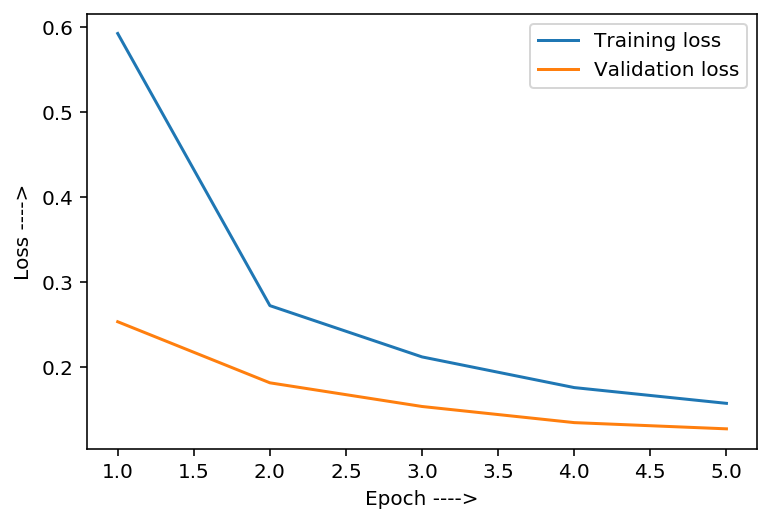

In [22]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.3),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.3),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adadelta(model.parameters(),lr=0.5)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adadelta optimizer) , Epoch : 10 , Hidden Layer : 1 , ReLU Activation

No Of Parameters 109386
Epoch: 1/10..  Training Loss: 0.503..  Test Loss: 0.227..  Test Accuracy: 0.932
Epoch: 2/10..  Training Loss: 0.221..  Test Loss: 0.162..  Test Accuracy: 0.954
Epoch: 3/10..  Training Loss: 0.164..  Test Loss: 0.144..  Test Accuracy: 0.957
Epoch: 4/10..  Training Loss: 0.137..  Test Loss: 0.115..  Test Accuracy: 0.966
Epoch: 5/10..  Training Loss: 0.121..  Test Loss: 0.115..  Test Accuracy: 0.967
Epoch: 6/10..  Training Loss: 0.107..  Test Loss: 0.121..  Test Accuracy: 0.967
Epoch: 7/10..  Training Loss: 0.094..  Test Loss: 0.111..  Test Accuracy: 0.969
Epoch: 8/10..  Training Loss: 0.086..  Test Loss: 0.099..  Test Accuracy: 0.974
Epoch: 9/10..  Training Loss: 0.077..  Test Loss: 0.102..  Test Accuracy: 0.971
Epoch: 10/10..  Training Loss: 0.073..  Test Loss: 0.100..  Test Accuracy: 0.973
38.198198842583224


[]

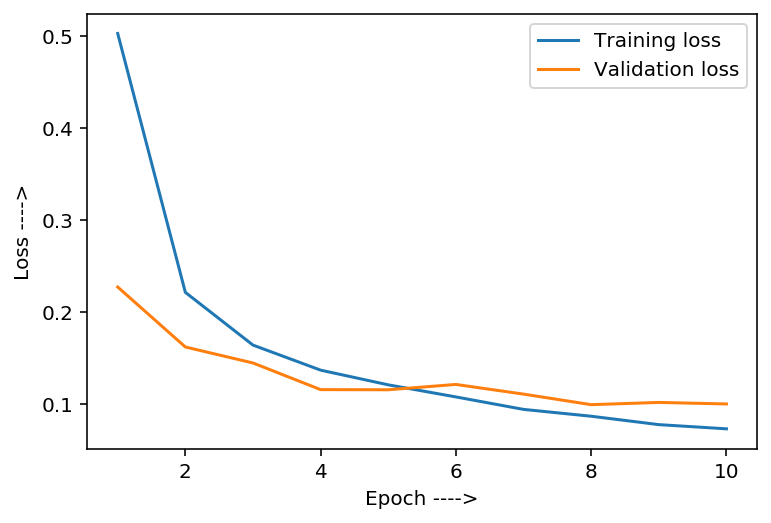

In [23]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.Dropout(0.2),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adadelta(model.parameters(),lr=0.6)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Experiment :10 - (Adadelta optimizer) , Epoch : 5 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 113546
Epoch: 1/5..  Training Loss: 0.842..  Test Loss: 0.295..  Test Accuracy: 0.912
Epoch: 2/5..  Training Loss: 0.391..  Test Loss: 0.219..  Test Accuracy: 0.939
Epoch: 3/5..  Training Loss: 0.299..  Test Loss: 0.190..  Test Accuracy: 0.948
Epoch: 4/5..  Training Loss: 0.265..  Test Loss: 0.166..  Test Accuracy: 0.956
Epoch: 5/5..  Training Loss: 0.235..  Test Loss: 0.163..  Test Accuracy: 0.956
123.46121979132295


[]

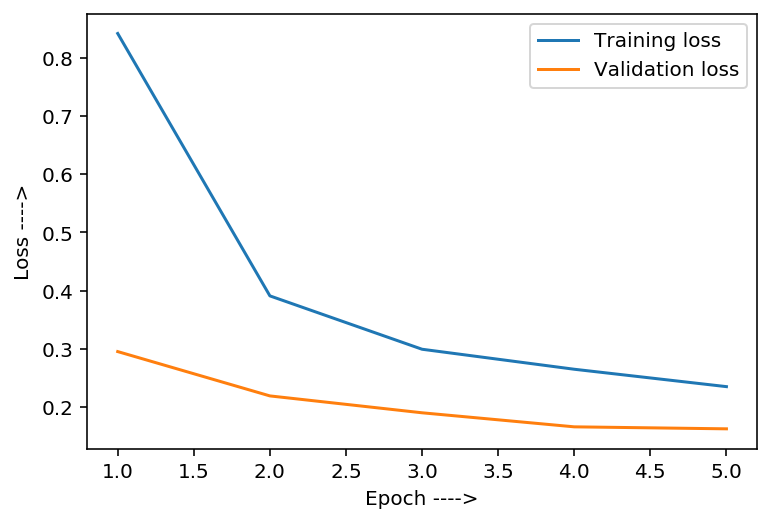

In [24]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adadelta(model.parameters(),lr=0.45)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=5
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### (Adadelta optimizer) , Epoch : 10 , Hidden Layer : 2 , ReLU Activation

No Of Parameters 113546
Epoch: 1/10..  Training Loss: 0.895..  Test Loss: 0.323..  Test Accuracy: 0.907
Epoch: 2/10..  Training Loss: 0.405..  Test Loss: 0.229..  Test Accuracy: 0.936
Epoch: 3/10..  Training Loss: 0.319..  Test Loss: 0.203..  Test Accuracy: 0.943
Epoch: 4/10..  Training Loss: 0.280..  Test Loss: 0.193..  Test Accuracy: 0.951
Epoch: 5/10..  Training Loss: 0.251..  Test Loss: 0.166..  Test Accuracy: 0.955
Epoch: 6/10..  Training Loss: 0.231..  Test Loss: 0.164..  Test Accuracy: 0.958
Epoch: 7/10..  Training Loss: 0.220..  Test Loss: 0.166..  Test Accuracy: 0.956
Epoch: 8/10..  Training Loss: 0.200..  Test Loss: 0.170..  Test Accuracy: 0.958
Epoch: 9/10..  Training Loss: 0.200..  Test Loss: 0.153..  Test Accuracy: 0.963
Epoch: 10/10..  Training Loss: 0.194..  Test Loss: 0.153..  Test Accuracy: 0.962
102.01075718551874


[]

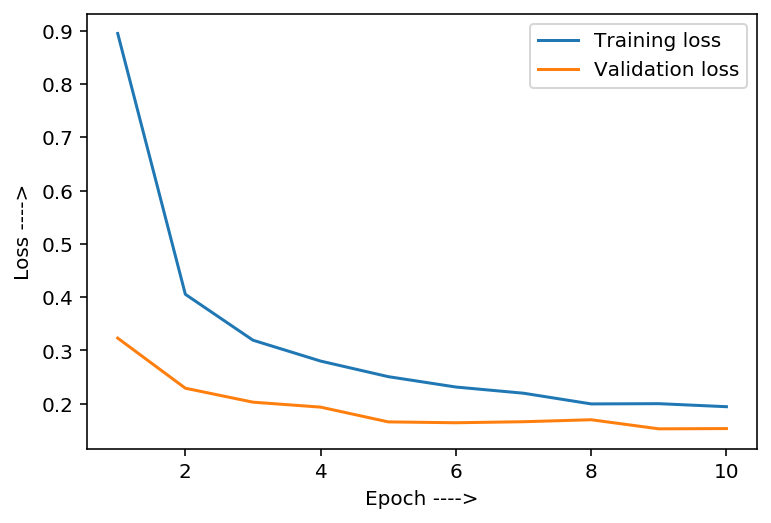

In [25]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.Dropout(0.4),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

print("No Of Parameters",sum([p.numel() for p in model.parameters()]))

# Defining Optimizer
optimizer=optim.Adadelta(model.parameters(),lr=0.5)

criterion = nn.NLLLoss()
images, labels = next(iter(train_loader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)
loss.backward()


# Training

epochs=10
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()  # to make zero optimization for every iteration afresh optimzation.
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()   # holding all gradients after updation.
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()  # to tell model its for evaluation not for training
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()   #
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

print(running_loss)

xlabels=np.arange(1, epochs+1)
plt.xlabel("Epoch ---->")
plt.ylabel("Loss ---->")
plt.plot(xlabels,train_losses, label='Training loss')
plt.plot(xlabels,test_losses, label='Validation loss')
plt.legend()
plt.plot()

#### Conclusion : In above experiments with different optimizers and parameters we got max accuracy on validation set 0.973 in Experiment 9 with below parameters

**Adadelta(lr=0.5)
Hidden Layer 1 : 128
Dropout : 0.3
Parameters : 109386**